In [1]:
import numpy as np
import pandas as pd

import shap
shap.initjs()

import pickle
import importlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.tree import export_graphviz
from graphviz import Source

import main
importlib.reload(main);

import load_and_prepare
importlib.reload(load_and_prepare);

import config
importlib.reload(config);

from models import fit_predict, metrics, utils as m_utils
importlib.reload(fit_predict);
importlib.reload(metrics);
importlib.reload(m_utils);

In [2]:
def get_figsize():
    return plt.rcParams['figure.figsize'].copy()


def set_figsize(width, height):
    plt.rcParams['figure.figsize'] = width, height
    
    
class PltResizer:
    def __init__(self, new_size: tuple):
        self._new_size = new_size
        self._old_size = None
        
    def __enter__(self):
        self._old_size = get_figsize()
        set_figsize(*self._new_size)
        
    def __exit__(self, *args):
        set_figsize(*self._old_size)
        
        
def change_figsize(width, height) -> PltResizer:
    return PltResizer((width, height))


def label_distplots(values, labels, kde=True, hist=True, bins=None):
    for label in labels.unique():
        sns.distplot(values[labels == label], kde=kde, hist=hist, label=f'Label = {label}', norm_hist=True, bins=bins)
    plt.legend();

In [3]:
%%time
# features = main.prepare_features()

Wall time: 0 ns


In [4]:
%%time
# with open('features.pkl', 'wb') as f:
#     pickle.dump(features, f, protocol=pickle.HIGHEST_PROTOCOL)

Wall time: 0 ns


In [5]:
%%time
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
features.set_index('client_id', inplace=True)

Wall time: 7.56 s


In [6]:
features.shape

(400162, 266)

In [7]:
features.head()

,gender_M,gender_F,gender_U,age,days_from_min_to_issue,days_from_min_to_redeem,issue_redeem_delay,price_from_0_sum,price_from_0_mean,price_from_98_sum,...,vendor_id_f6,vendor_id_f7,vendor_id_f8,vendor_id_f9,vendor_id_f10,netto_median,is_own_trademark_sum,is_own_trademark_mean,is_alcohol_sum,is_alcohol_mean
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,0,1,45,122.886458,275.045706,152.159248,48,0.923077,4,...,0.707041,1.447112,-0.046974,1.415846,-0.382967,0.400,4,0.076923,0,0.000000
000036f903,0,1,0,72,5.812558,18.759468,12.946910,141,0.870370,19,...,0.163341,2.858031,0.566178,1.881164,0.442562,0.350,14,0.086420,1,0.006173
000048b7a6,0,1,0,68,619.797836,-1.000000,-1.000000,48,0.857143,4,...,0.814286,1.347162,1.095487,1.235258,-0.654004,0.085,3,0.053571,0,0.000000
000073194a,0,1,0,60,48.772176,233.703970,184.931794,48,0.585366,20,...,1.064204,0.637906,1.268617,1.999638,0.142837,0.400,3,0.036585,9,0.109756
00007c7133,0,0,1,67,47.911690,635.953646,588.041956,66,0.795181,10,...,0.113476,1.315521,1.135064,1.444339,-0.665397,0.415,10,0.120482,0,0.000000


In [8]:
for suffix in ('', '_30d'):
    features[f'ratio_sum_express_to_regular_points_spent{suffix}'] = (
        features[f'express_points_spent_sum{suffix}'] /
        features[f'regular_points_spent_sum{suffix}']
    ).replace(np.inf, 999999).fillna(-2)
    features[f'ratio_sum_express_points_spent_to_purchase_sum{suffix}'] = (
        features[f'express_points_spent_sum{suffix}'] /
        features[f'purchase_sum_sum{suffix}']
    ).replace(np.inf, 999999).fillna(-2)

In [9]:
%%time
train = load_and_prepare.load_train()
test = load_and_prepare.load_test()
indices_train = train.index
indices_test = test.index

Wall time: 746 ms


In [10]:
%%time

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
y_train = m_utils.make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

# TODO: Instead of this do cross validation and grid search
indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=config.RANDOM_STATE,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)

Wall time: 2.92 s


In [11]:
def learn_valid(model, split_random_state):
    indices_learn, indices_valid = train_test_split(
        train.index,
        test_size=0.3,
        random_state=split_random_state,
    )

    X_learn = features.loc[indices_learn, :]
    treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
    target_learn = train.loc[indices_learn, 'target'].values

    X_valid = features.loc[indices_valid, :]
    treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
    target_valid = train.loc[indices_valid, 'target'].values
    
#     mask_learn = (X_learn['days_from_min_to_redeem'] <= 714) & (X_learn['days_from_min_to_redeem'] < 723)
#     X_learn = X_learn[mask_learn]
#     treatment_learn = treatment_learn[mask_learn]
#     target_learn = target_learn[mask_learn]
    
#     mask_valid = (X_valid['days_from_min_to_redeem'] <= 714) & (X_valid['days_from_min_to_redeem'] < 723)
#     X_valid = X_valid[mask_valid]
#     treatment_valid = treatment_valid[mask_valid]
#     target_valid = target_valid[mask_valid]
    
    clf = fit_predict.uplift_fit(model, X_learn, treatment_learn, target_learn)
    learn_pred = fit_predict.uplift_predict(clf, X_learn)
    learn_scores = metrics.uplift_metrics(learn_pred, treatment_learn, target_learn)
    valid_pred = fit_predict.uplift_predict(clf, X_valid)
    valid_scores = metrics.uplift_metrics(valid_pred, treatment_valid, target_valid)

    print(f'Learn scores: {learn_scores}')
    print(f'Valid scores: {valid_scores}')
    
    return clf

In [12]:
%%time

cb_clf = CatBoostClassifier(
    eval_metric='Logloss', #'AUC',
    random_seed=config.RANDOM_STATE,
    nan_mode='Forbidden',
    task_type='GPU',
    verbose=False,
    n_estimators=500,
    max_depth=5,
    max_bin=100,
    od_wait=200,
#     max_features=50,
    od_type='Iter',
    learning_rate=0.001,
)


for rs in (1, 2, 3):
    print(f'Random state = {rs}')
    trained_clf = learn_valid(cb_clf, rs)


Random state = 1
Learn scores: {'roc_auc': 0.5317442880847668, 'uplift': 0.09533716409915538}
Valid scores: {'roc_auc': 0.5253615663745086, 'uplift': 0.09415227873733778}
Random state = 2
Learn scores: {'roc_auc': 0.5305619966268793, 'uplift': 0.09606758042876495}
Valid scores: {'roc_auc': 0.5263282278572073, 'uplift': 0.08991899900060807}
Random state = 3
Learn scores: {'roc_auc': 0.5316044921477658, 'uplift': 0.09742764406495663}
Valid scores: {'roc_auc': 0.5268476555768321, 'uplift': 0.09019153309037653}
Wall time: 53.4 s


In [20]:
%%time

cb_clf = CatBoostClassifier(
    eval_metric='Logloss', #'AUC',
    random_seed=config.RANDOM_STATE,
    nan_mode='Forbidden',
    task_type='GPU',
    verbose=False,
    n_estimators=500,
    max_depth=5,
    max_bin=100,
    od_wait=200,
#     max_features=50,
    od_type='Iter',
    learning_rate=0.001,
)

clf = fit_predict.uplift_fit(cb_clf, X_train, treatment_train, target_train)
train_pred = fit_predict.uplift_predict(clf, X_train)
train_scores = metrics.uplift_metrics(train_pred, treatment_train, target_train)
print(f'Train scores: {train_scores}')
test_pred = fit_predict.uplift_predict(clf, X_test)

main.save_submission(indices_test, test_pred, 'submission_ratio_sum_features_d5_est500.csv')

Train scores: {'roc_auc': 0.5283866440417957, 'uplift': 0.08796801503086371}
Wall time: 20.1 s


In [21]:
importances = m_utils.get_feature_importances(clf, features.columns)
# importances[importances['column'] == 'ratio_sum_express_to_regular_points_spent']
importances.iloc[:30, :]

,column,importance
5,days_from_min_to_redeem,90.696026
267,ratio_sum_express_points_spent_to_purchase_sum,2.131664
269,ratio_sum_express_points_spent_to_purchase_sum...,1.126856
235,level_4_f4,1.050849
3,age,1.047801
38,express_points_spent_sum,0.357535
239,segment_id_f3,0.245621
121,regular_points_received_sum_30d,0.213097
122,regular_points_received_max_30d,0.157619
46,is_regular_points_received_sum,0.148787


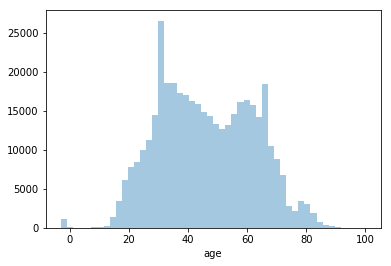

In [143]:
sns.distplot(features.['age'], kde=False)

In [144]:
%%time
sample = features.sample(n=20000, random_state=config.RANDOM_STATE)
explainer = shap.TreeExplainer(trained_clf)
shap_values = explainer.shap_values(sample)

Wall time: 2.54 s


In [79]:
before = np.arange(len(sample))[(sample.days_from_min_to_redeem > 600) & (sample.days_from_min_to_redeem < 710)][:100]
before[:10]

array([ 7, 10, 11, 12, 15, 26, 34, 38, 40, 46])

In [80]:
during = np.arange(len(sample))[(sample.days_from_min_to_redeem > 714) & (sample.days_from_min_to_redeem < 720)][:100]
during[:10]

array([ 23, 129, 163, 171, 243, 252, 269, 286, 302, 314])

In [81]:
after = np.arange(len(sample))[(sample.days_from_min_to_redeem > 725) & (sample.days_from_min_to_redeem < 760)][:100]
after[:10]

array([ 75, 156, 183, 279, 308, 351, 364, 433, 503, 563])

In [89]:
ids = np.arange(len(sample))[(sample.days_from_min_to_redeem > 650) & (sample.days_from_min_to_redeem < 800)]
ids = np.random.choice(ids, 100, replace=False)
shap.force_plot(explainer.expected_value, shap_values[ids,:], sample.iloc[ids,:])

In [94]:
sample.iloc[ids, :].iloc[45, :]['days_from_min_to_redeem']

688.9311342592592

In [96]:
i = 45
shap.force_plot(explainer.expected_value, shap_values[ids,:][i,:], sample.iloc[ids, :].iloc[i,:])

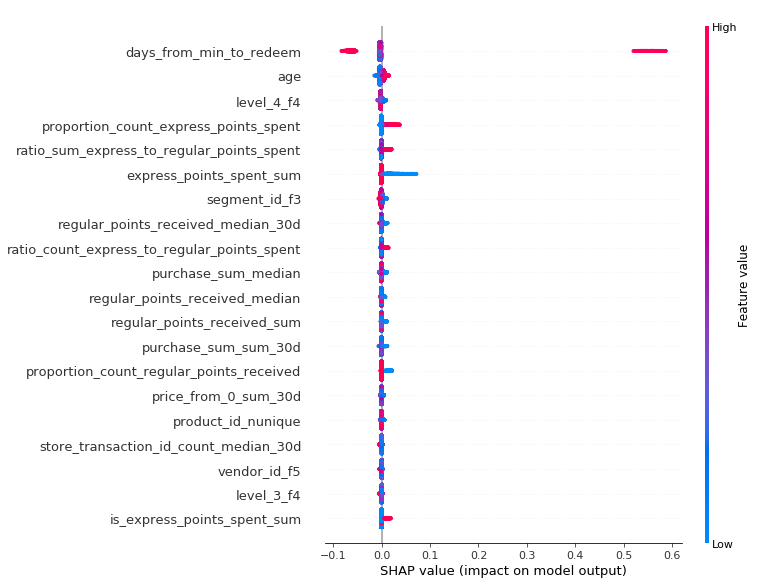

In [145]:
shap.summary_plot(shap_values, sample)

In [98]:
DecisionTreeClassifier?

## passthrough = False

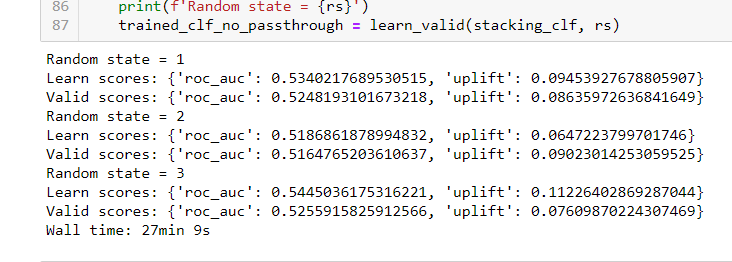

In [148]:
features = features.reindex(columns=good_features)
features.shape

(400162, 122)

In [151]:
%%time

lgbm_rf_clf = LGBMClassifier(
    boosting_type='rf',
    learning_rate=0.01,
    n_estimators=100,
    max_depth=5, 
    min_data_in_leaf=1000,
    num_leaves=40,
    max_features=50,
    max_bin=100,
    bagging_freq=1,
    bagging_fraction=0.5,
    eval_metric='Logloss',
    random_state=config.RANDOM_STATE
)

lgbm_gbdt_clf = LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.01,
    n_estimators=100,
    max_depth=4, 
    min_data_in_leaf=1000,
    num_leaves=20,
    max_features=50,
    max_bin=100,
    bagging_freq=3,
    eval_metric='Logloss',
    random_state=config.RANDOM_STATE
)


cb_clf = CatBoostClassifier(
    eval_metric='Logloss', #'AUC',
    random_seed=config.RANDOM_STATE,
    nan_mode='Forbidden',
    task_type='GPU',
    verbose=False,
    n_estimators=100,
    max_depth=4,
    max_bin=100,
    max_features=50
    od_wait=200,
    od_type='Iter',
    learning_rate=0.01,
)
                           


final_clf = LogisticRegression(
    penalty='l2',
    C=1.0,
)


classifiers = [
    ('lgbm_gbdt_est50_d4', clone(lgbm_gbdt_clf).set_params(n_estimators=50)),
    ('lgbm_gbdt_est100_d4', clone(lgbm_gbdt_clf).set_params(n_estimators=100)),
    ('lgbm_gbdt_est200_d4', clone(lgbm_gbdt_clf).set_params(n_estimators=200)),
    ('lgbm_gbdt_est50_d3', clone(lgbm_gbdt_clf).set_params(n_estimators=50)),
    ('lgbm_gbdt_est100_d3', clone(lgbm_gbdt_clf).set_params(n_estimators=100)),
    ('lgbm_gbdt_est200_d3', clone(lgbm_gbdt_clf).set_params(n_estimators=200)),
    ('cb_est50_d3', clone(lgbm_gbdt_clf).set_params(n_estimators=50)),
    ('cb_est100_d3', clone(lgbm_gbdt_clf).set_params(n_estimators=100)),
    ('cb_est200_d3', clone(lgbm_gbdt_clf).set_params(n_estimators=200)),
    ('cb_est50_d4', clone(lgbm_gbdt_clf).set_params(n_estimators=50)),
    ('cb_est100_d4', clone(lgbm_gbdt_clf).set_params(n_estimators=100)),
    ('cb_est200_d4', clone(lgbm_gbdt_clf).set_params(n_estimators=200)),
    ('lgbm_rf_est10000_d4', clone(lgbm_rf_clf).set_params(max_depth=4)),
    ('lgbm_rf_est10000_d5', clone(lgbm_rf_clf).set_params(max_depth=5)),
    ('lgbm_rf_est10000_d6', clone(lgbm_rf_clf).set_params(max_depth=6)),   
]


stacking_clf = StackingClassifier(
    estimators=classifiers,
    final_estimator=final_clf,
    cv=3,
    stack_method='predict_proba',
    n_jobs=1,
    passthrough=False
)

for rs in (1, 2, 3):
    print(f'Random state = {rs}')
    trained_clf_no_passthrough = learn_valid(stacking_clf, rs)

Random state = 1
Learn scores: {'roc_auc': 0.5492612120048312, 'uplift': 0.1252439463070043}
Valid scores: {'roc_auc': 0.5253983721286405, 'uplift': 0.08222143360847078}
Random state = 2
Learn scores: {'roc_auc': 0.5414020621369368, 'uplift': 0.12082221243137647}
Valid scores: {'roc_auc': 0.5272392207167087, 'uplift': 0.09476381776962328}
Random state = 3
Learn scores: {'roc_auc': 0.5450686514370403, 'uplift': 0.1158782845603139}
Valid scores: {'roc_auc': 0.5275861574269683, 'uplift': 0.08280215676974745}
Wall time: 17min 43s


In [152]:
trained_clf_no_passthrough.final_estimator_.coef_

array([[2.40105288, 2.58435047, 1.60758652, 0.44270742, 0.43987781,
        0.05966766, 0.20541532]])

In [118]:
clf = trained_clf_no_passthrough.final_estimator_
columns = list(range(7))
feature_importances = m_utils.get_feature_importances(clf, columns)
feature_importances.head(30)

,column,importance
2,2,0.925908
3,3,0.053676
4,4,0.012243
6,6,0.008173
0,0,0.000000
1,1,0.000000
5,5,0.000000


In [119]:
importances = pd.DataFrame(index=features.columns)
for i, est in enumerate(trained_clf_no_passthrough.estimators_):
    importances[f'est_{i}'] = est.feature_importances_
importances.head(10)

,est_0,est_1,est_2,est_3,est_4,est_5,est_6
gender_M,0,0,0,0,0,2,0.000000
gender_F,0,0,0,3,6,8,0.000000
gender_U,0,0,0,0,8,9,0.000000
age,29,55,90,106,156,203,0.008887
days_from_min_to_issue,18,19,25,29,42,65,0.058738
days_from_min_to_redeem,100,186,272,2057,2103,2147,0.507490
issue_redeem_delay,0,6,46,39,83,128,0.037953
issue_year,0,0,0,0,0,0,0.000000
issue_month,0,0,0,2,3,5,0.000000
issue_day,0,2,6,15,35,58,0.000000


In [128]:
importances_normed = importances / importances.sum() * 100
importances_normed['sum'] = importances_normed.sum(axis=1)
importances_normed.sort_values('sum', ascending=False, inplace=True)
importances_normed.head(30)

,est_0,est_1,est_2,est_3,est_4,est_5,est_6,sum
days_from_min_to_redeem,18.726592,17.448405,12.528789,23.876959,17.532305,13.668195,50.749037,154.530281
express_points_spent_sum,3.745318,4.878049,5.343160,4.956471,3.968320,3.240387,0.000000,26.131705
age,5.430712,5.159475,4.145555,1.230412,1.300542,1.292335,0.888662,19.447693
express_points_spent_sum_30d,4.868914,3.095685,1.750345,1.834010,1.467278,1.177744,0.000000,14.193976
store_transaction_id_count_mean,3.558052,2.157598,1.105481,1.834010,1.475615,1.222307,2.698846,14.051911
days_from_min_to_issue,3.370787,1.782364,1.151543,0.336622,0.350146,0.413802,5.873784,13.279047
purchase_sum_sum_30d,2.996255,3.095685,1.888531,1.508996,1.292205,1.152279,0.542134,12.476084
regular_points_received_median_30d,1.685393,2.251407,1.427913,1.021474,0.942059,0.821238,4.283020,12.432504
level_4_f4,2.621723,3.377111,2.257024,1.265235,1.217174,1.094983,0.000000,11.833250
level_3_f4,2.247191,1.500938,1.059420,0.928613,0.958733,0.923097,3.325665,10.943656


In [123]:
importances_normed.shape

(298, 8)

In [155]:
importances_normed#[importances_normed['sum'] <= 1]

,est_0,est_1,est_2,est_3,est_4,est_5,est_6,sum
days_from_min_to_redeem,18.726592,17.448405,12.528789,23.876959,17.532305,13.668195,50.749037,154.530281
express_points_spent_sum,3.745318,4.878049,5.343160,4.956471,3.968320,3.240387,0.000000,26.131705
age,5.430712,5.159475,4.145555,1.230412,1.300542,1.292335,0.888662,19.447693
express_points_spent_sum_30d,4.868914,3.095685,1.750345,1.834010,1.467278,1.177744,0.000000,14.193976
store_transaction_id_count_mean,3.558052,2.157598,1.105481,1.834010,1.475615,1.222307,2.698846,14.051911
days_from_min_to_issue,3.370787,1.782364,1.151543,0.336622,0.350146,0.413802,5.873784,13.279047
purchase_sum_sum_30d,2.996255,3.095685,1.888531,1.508996,1.292205,1.152279,0.542134,12.476084
regular_points_received_median_30d,1.685393,2.251407,1.427913,1.021474,0.942059,0.821238,4.283020,12.432504
level_4_f4,2.621723,3.377111,2.257024,1.265235,1.217174,1.094983,0.000000,11.833250
level_3_f4,2.247191,1.500938,1.059420,0.928613,0.958733,0.923097,3.325665,10.943656


In [126]:
good_features = importances_normed[importances_normed['sum'] > 1].index.tolist()
len(good_features)

122

In [127]:
good_features

['days_from_min_to_redeem',
 'express_points_spent_sum',
 'age',
 'express_points_spent_sum_30d',
 'store_transaction_id_count_mean',
 'days_from_min_to_issue',
 'purchase_sum_sum_30d',
 'regular_points_received_median_30d',
 'level_4_f4',
 'level_3_f4',
 'is_regular_points_received_sum',
 'product_id_f5',
 'product_id_f14',
 'product_id_count_mean',
 'store_id_f1_30d',
 'express_points_spent_min_30d',
 'product_id_f20',
 'issue_redeem_delay',
 'product_id_f16',
 'store_id_f5',
 'is_alcohol_mean',
 'brand_id_f10',
 'orders_interval_std',
 '2Morning_sum_30d',
 'vendor_id_f10',
 'days_from_last_order',
 'product_id_nunique',
 'product_id_f3',
 'segment_id_f3',
 'regular_points_received_max_30d',
 'store_id_f7_30d',
 'product_id_f24',
 'product_id_f27',
 'orders_interval_median',
 'store_transaction_id_count_max',
 'express_points_spent_min',
 'trn_sum_from_iss_median_30d',
 'brand_id_f9',
 'product_id_count_mean_30d',
 'product_id_f17',
 '2Afternoon_sum',
 'product_id_f2',
 'purchase_sum_median',
 'product_id_f9',
 'product_id_f25',
 'vendor_id_f5',
 'issue_dayofyear',
 'is_own_trademark_mean',
 'brand_id_f3',
 '5Morning_sum',
 'segment_id_f2',
 'regular_points_received_sum_30d',
 'product_id_nunique_30d',
 'level_2_f1',
 'level_4_f5',
 'vendor_id_f8',
 'brand_id_f1',
 'store_id_f2',
 'brand_id_f8',
 'store_id_f6',
 'vendor_id_f4',
 'regular_points_received_max',
 'store_id_f1',
 'netto_median',
 'brand_id_f2',
 'product_id_f7',
 'orders_interval_mean',
 'store_id_f5_30d',
 'vendor_id_f3',
 'orders_interval_min_30d',
 'regular_points_received_median',
 '2Morning_sum',
 'product_id_f4',
 'purchase_sum_max_30d',
 'product_id_f28',
 'store_transaction_id_count_median_30d',
 '5Afternoon_sum',
 'regular_points_spent_sum',
 'store_transaction_id_count_median',
 'product_id_count',
 'brand_id_f5',
 'vendor_id_f2',
 'brand_id_f7',
 'level_3_f3',
 'regular_points_spent_min_30d',
 'store_id_f8',
 'product_id_f29',
 'product_id_count_30d',
 'purchase_sum_max',
 'orders_interval_median_30d',
 'level_3_f1',
 'orders_interval_min',
 'brand_id_f6',
 'store_transaction_id_count_max_30d',
 'vendor_id_f7',
 'level_2_f3',
 'product_id_f21',
 '3Afternoon_sum',
 'vendor_id_f6',
 'product_id_f19',
 'segment_id_f1',
 'orders_interval_last',
 'level_3_f2',
 'product_id_f23',
 'store_id_f2_30d',
 '5Morning_sum_30d',
 'store_transaction_id_count_mean_30d',
 'vendor_id_f1',
 'issue_day',
 'segment_id_f4',
 'product_id_f13',
 'orders_interval_max',
 'level_4_f2',
 'product_id_f1',
 'product_id_f26',
 'level_2_f2',
 'product_id_f32',
 'store_id_f4',
 'orders_interval_max_30d',
 'product_quantity_max_mean',
 'store_id_f6_30d',
 '4Morning_count']

## passthrough = True

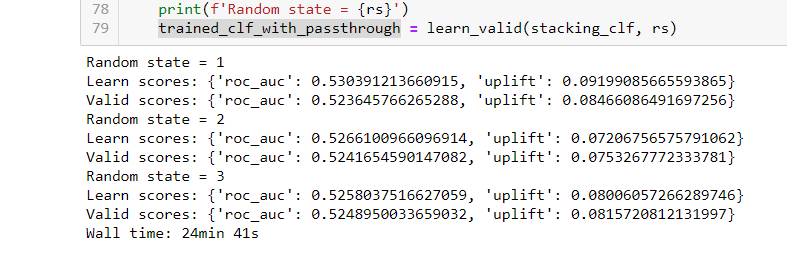

In [117]:
%%time

rf_clf = LGBMClassifier(
    boosting_type='rf',
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=5, 
    min_data_in_leaf=1000,
    num_leaves=40,
    max_features=50,
    max_bin=100,
    bagging_freq=1,
    bagging_fraction=0.5,
    eval_metric='Logloss',
    random_state=config.RANDOM_STATE
)

gbdt_clf = LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.01,
    n_estimators=100,
    max_depth=4, 
    min_data_in_leaf=1000,
    num_leaves=20,
    max_features=50,
    max_bin=100,
    bagging_freq=3,
    eval_metric='Logloss',
    random_state=config.RANDOM_STATE
)


dt_clf = DecisionTreeClassifier(
    max_depth=7,
    min_samples_leaf=1000,
    max_features=50,
    max_leaf_nodes=50,
    random_state=config.RANDOM_STATE,
)
                           
# final_clf = CatBoostClassifier(
#     eval_metric='Logloss', #'AUC',
#     random_seed=config.RANDOM_STATE,
#     nan_mode='Forbidden',
#     task_type='CPU',
#     verbose=False,
#     n_estimators=30,
#     max_depth=3,
#     max_bin=20,
#     od_wait=200,
#     od_type='Iter',
#     learning_rate=0.01,
# )

final_clf = DecisionTreeClassifier(
    max_depth=7,
    min_samples_leaf=1000,
    max_features=50,
    max_leaf_nodes=50,
    random_state=config.RANDOM_STATE,
)

classifiers = [
    ('lgbm_gbdt_est50_d4', clone(gbdt_clf).set_params(n_estimators=50)),
    ('lgbm_gbdt_est100_d4', clone(gbdt_clf).set_params(n_estimators=100)),
    ('lgbm_gbdt_est200_d4', clone(gbdt_clf).set_params(n_estimators=200)),
    ('lgbm_rf_est1000_d4', clone(rf_clf).set_params(max_depth=4)),
    ('lgbm_rf_est1000_d5', clone(rf_clf).set_params(max_depth=5)),
    ('lgbm_rf_est1000_d6', clone(rf_clf).set_params(max_depth=6)),
    ('dt_d7', clone(dt_clf))
]

# voting_clf = VotingClassifier(classifiers, voting='soft')

stacking_clf = StackingClassifier(
    estimators=classifiers,
    final_estimator=final_clf,
    cv=3,
    stack_method='predict_proba',
    n_jobs=1,
    passthrough=True
)

for rs in (1,): # 2, 3):
    print(f'Random state = {rs}')
    trained_clf_with_passthrough = learn_valid(stacking_clf, rs)

Random state = 1
Learn scores: {'roc_auc': 0.531875358422256, 'uplift': 0.10613878132970034}
Valid scores: {'roc_auc': 0.5178977925239296, 'uplift': 0.06988011247133963}
Wall time: 8min 12s


In [145]:
clf = trained_clf_with_passthrough.final_estimator_
columns = list(range(7)) + features.columns.tolist()
feature_importances = m_utils.get_feature_importances(clf, columns)
feature_importances.head(30)

,column,importance
0,0,0.674327
1,1,0.061831
4,4,0.047063
11,days_from_min_to_issue,0.035531
10,age,0.019703
5,5,0.018090
42,purchase_sum_median,0.017861
142,express_points_spent_sum_30d,0.011637
21,product_id_count,0.010604
248,product_id_f19,0.010533


In [144]:
(features['gender_M'] > 0.556).sum()

66807

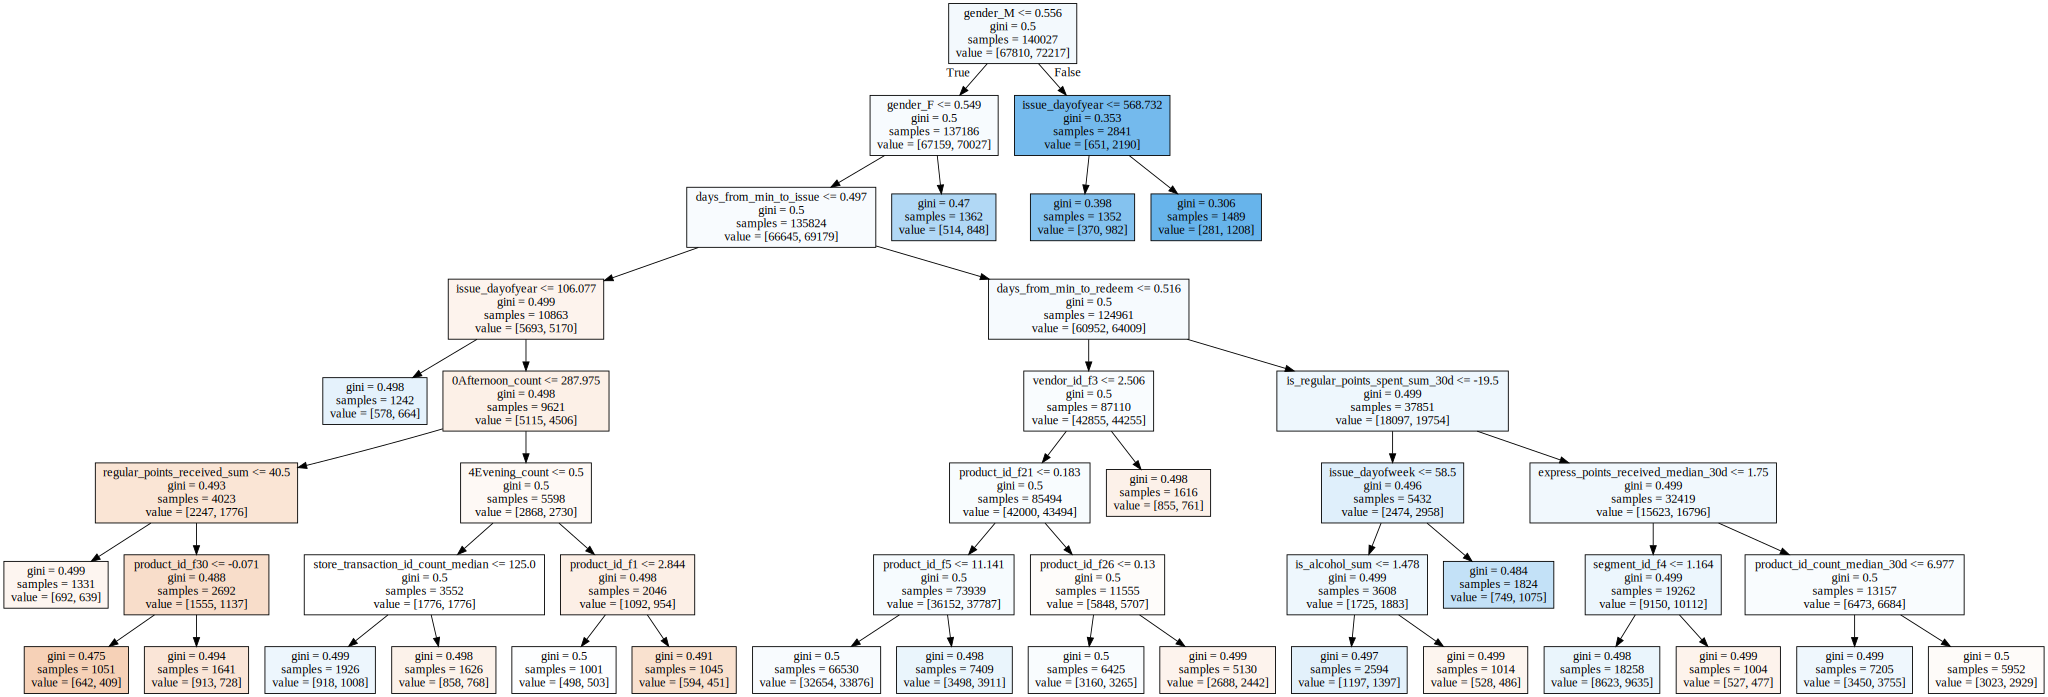

In [139]:
Source(export_graphviz(clf, out_file=None, feature_names=columns,  filled=True))

In [134]:
feature_importances.loc[feature_importances['column'].isin([0, 1, 2, 3, 4, 5, 6]), :]

,column,importance
303,5,0.0
302,4,0.0
301,3,0.0
300,2,0.0
299,1,0.0
298,0,0.0
304,6,0.0


In [106]:
importances = pd.DataFrame(index=features.columns)
for i, est in enumerate(trained_clf_no_passthrough.estimators_):
    importances[f'est_{i}'] = est.feature_importances_
importances.head(10)

,est_0,est_1,est_2,est_3,est_4,est_5,est_6
gender_M,0,0,0,0,0,1,0.000000
gender_F,0,0,0,3,4,6,0.000000
gender_U,0,0,0,1,6,13,0.000000
age,18,35,73,213,271,349,0.018807
days_from_min_to_issue,27,30,34,26,41,66,0.000000
days_from_min_to_redeem,100,188,269,2058,2113,2155,0.195454
issue_redeem_delay,4,14,39,42,71,108,0.070810
issue_year,0,0,0,1,1,2,0.048737
issue_month,0,0,0,1,1,9,0.000000
issue_day,0,0,6,18,36,61,0.000000


In [112]:
importances_normed = importances / importances.sum() * 100
importances_normed['sum'] = importances_normed.sum(axis=1)
importances_normed.sort_values('sum', ascending=False, inplace=True)
importances_normed.head()

,est_0,est_1,est_2,est_3,est_4,est_5,est_6,sum
days_from_min_to_redeem,17.730496,16.433566,11.982183,23.780911,17.808681,13.540685,19.545364,120.821886
express_points_spent_sum,7.624113,6.381119,5.122494,6.667437,5.427729,4.278982,4.820731,40.322606
age,3.191489,3.059441,3.251670,2.461290,2.284029,2.192900,1.880656,18.321474
store_id_f5,4.787234,2.534965,1.603563,2.391957,1.963759,1.633679,0.000000,14.915158
purchase_sum_max,7.269504,4.108392,2.628062,0.184886,0.303413,0.358153,0.000000,14.852409


In [ ]:
trained_clf_no_passthrough.estimators_

In [21]:
%%time

lgbm_params = {
    'boosting_type':'rf',
    'learning_rate':0.01,
    'n_estimators':100,
    'max_depth':4, 
    'min_data_in_leaf':1000,
    'num_leaves':20,
    'max_bin':100,
    'subsample':0.8, 
    'colsample_bytree': 0.8, 
    'reg_alpha':0.01,
    'reg_lambda':0.01,
    'bagging_freq':3,
    'eval_metric':'Logloss',
    'od_type': 'Iter', 
    'od_wait':200,
     'random_state': config.RANDOM_STATE
}


clf_ = LGBMClassifier(**lgbm_params)


# clf_ = CatBoostClassifier(
#     eval_metric='Logloss', #'AUC',
#     random_seed=config.RANDOM_STATE,
#     nan_mode='Forbidden',
#     task_type='GPU',
#     verbose=False,
#     n_estimators=200,
#     max_depth=5,
#     max_bin=100,
#     od_wait=200,
#     od_type='Iter',
#     learning_rate=0.01,
# )

classifiers = [
    (f'rs_{rs}', clf_.set_params(random_state=rs))
    for rs in range(5)
]

voting_clf = VotingClassifier(classifiers, voting='soft')


for rs in (1, 2, 3):
    print(f'Random state = {rs}')
    learn_valid(clf_, rs)


Random state = 1
Learn scores: {'roc_auc': 0.5380833841823018, 'uplift': 0.09926776075823707}
Valid scores: {'roc_auc': 0.5241199057464394, 'uplift': 0.08933236056891858}
Random state = 2
Learn scores: {'roc_auc': 0.534810659348682, 'uplift': 0.10223924975246113}
Valid scores: {'roc_auc': 0.5271888949257691, 'uplift': 0.09600570110531492}
Random state = 3
Learn scores: {'roc_auc': 0.5375875648430721, 'uplift': 0.10731662533513231}
Valid scores: {'roc_auc': 0.5256484535544428, 'uplift': 0.0840603341638001}
Wall time: 41.9 s


In [8]:
%%time

lgbm_params = {'learning_rate':0.01,'max_depth':4,'num_leaves':10, 'min_data_in_leaf':1000, 
               'subsample':0.8, 'colsample_bytree': 0.8, 'reg_alpha':0.01,'max_bin':100,
               'bagging_freq':3,'reg_lambda':0.01,'num_leaves':20, 'n_estimators':100, 
               'eval_metric':'Logloss', 'application':'binary', 
               'iterations':20000, 'od_type': 'Iter', 'od_wait':200,
               'device_type': 'cpu', 'random_state': config.RANDOM_STATE
}


clf_ = LGBMClassifier(**lgbm_params)



clf = fit_predict.uplift_fit(clf_, X_learn, treatment_learn, target_learn)
learn_pred = fit_predict.uplift_predict(clf, X_learn)
learn_scores = metrics.uplift_metrics(learn_pred, treatment_learn, target_learn)
valid_pred = fit_predict.uplift_predict(clf, X_valid)
valid_scores = metrics.uplift_metrics(valid_pred, treatment_valid, target_valid)

print(f'Learn scores: {learn_scores}')
print(f'Valid scores: {valid_scores}')

Learn scores: {'roc_auc': 0.54374183220455, 'uplift': 0.12196452839509841}
Valid scores: {'roc_auc': 0.5270688405556072, 'uplift': 0.1019068625267956}
Wall time: 11 s


In [28]:
feature_importances = m_utils.get_feature_importances(clf, features.columns)
feature_importances.head(30)

,column,importance
5,days_from_min_to_redeem,174
36,express_points_spent_sum,59
15,redeem_day,32
3,age,28
41,purchase_sum_median,26
17,redeem_dayofyear,24
273,level_4_f4,22
6,issue_redeem_delay,20
277,segment_id_f3,19
269,level_3_f4,19


In [154]:
%%time
clf = fit_predict.uplift_fit(trained_clf_no_passthrough, X_train, treatment_train, target_train)
train_pred = fit_predict.uplift_predict(clf, X_train)
train_scores = metrics.uplift_metrics(train_pred, treatment_train, target_train)
print(f'Train scores: {train_scores}')
test_pred = fit_predict.uplift_predict(clf, X_test)

main.save_submission(indices_test, test_pred, 'submission_trained_clf_no_passthrough.csv')

Train scores: {'roc_auc': 0.5446391319408541, 'uplift': 0.11701285299313702}
Wall time: 12min 48s


In [29]:
%%time
sample = features.sample(n=20000, random_state=config.RANDOM_STATE)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(sample.fillna(0))

C:\Users\emiliy.feldman\Anaconda3\lib\site-packages\shap\explainers\tree.py:194: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Wall time: 5.31 s


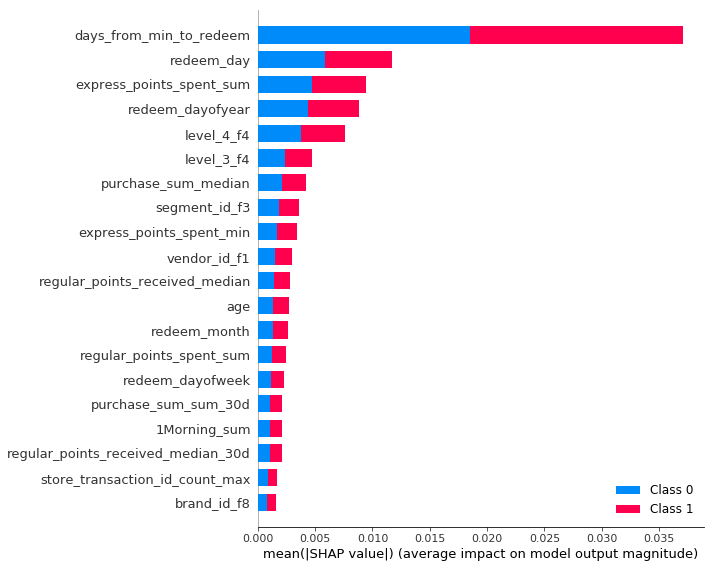

In [30]:
shap.summary_plot(shap_values, sample, plot_type="bar")

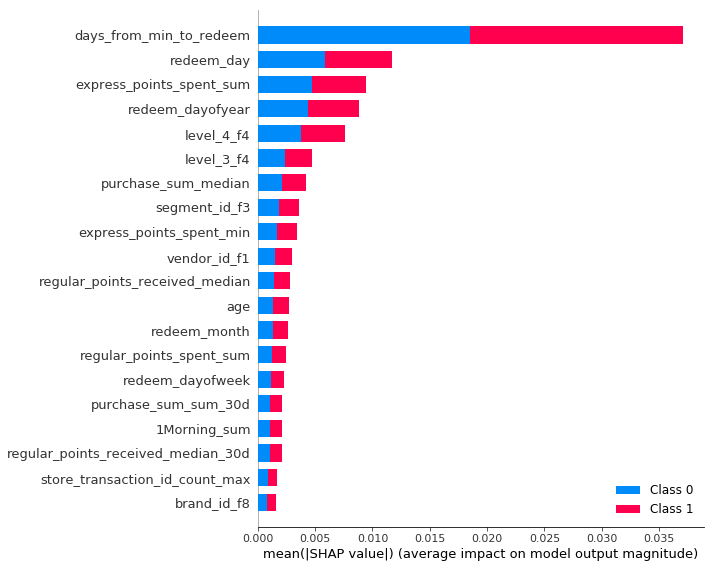

In [31]:
shap.summary_plot(shap_values, sample)

In [155]:
%%time
sample = features.sample(n=20000, random_state=config.RANDOM_STATE)
explainer = shap.TreeExplainer(clf)


Wall time: 1.33 s


In [160]:
small_sample = features.sample(n=100, random_state=config.RANDOM_STATE)

explainer = shap.TreeExplainer(clf)
# small_sample.index = np.arange(100)
small_shap_values = explainer.shap_values(small_sample)
shap.force_plot(explainer.expected_value, small_shap_values, small_sample)

In [85]:
N = 200_000
random_rows = np.random.choice(np.arange(len(X_train)), size=N, replace=False)
X_rand = X_train.iloc[random_rows, :]
y_rand = pd.Series(y_train[random_rows], index=X_rand.index)

In [102]:
X_rand.head()

,gender_M,gender_F,gender_U,age,days_from_min_to_issue,days_from_min_to_redeem,issue_redeem_delay,issue_year,issue_month,issue_day,...,vendor_id_f6,vendor_id_f7,vendor_id_f8,vendor_id_f9,vendor_id_f10,netto_median,is_own_trademark_sum,is_own_trademark_mean,is_alcohol_sum,is_alcohol_mean
client_id,,,,,,,,,,,,,,,,,,,,,
056d4cd274,0,0,1,56,232.617627,724.652396,492.034769,2017,11,23,...,1.156010,1.405742,1.508799,1.190106,-0.227142,0.3075,11,0.117021,0,0.000000
83f5cd0955,1,0,0,29,97.639028,764.010405,666.371377,2017,7,11,...,1.294325,1.802255,1.226681,0.525046,-0.187601,0.4600,14,0.159091,4,0.045455
ea71796408,0,1,0,61,374.638519,445.777118,71.138600,2018,4,14,...,0.467295,1.057593,1.499805,1.401968,-0.066034,0.4000,10,0.094340,1,0.009434
e8a6afd274,0,0,1,44,308.770440,647.926528,339.156088,2018,2,7,...,1.099697,1.837657,1.159791,0.693673,0.056321,0.5000,25,0.255102,7,0.071429
2ed056e369,0,0,1,64,257.688924,383.873600,126.184676,2017,12,18,...,1.574700,0.504587,1.562535,1.559417,-0.697756,0.4500,9,0.130435,0,0.000000


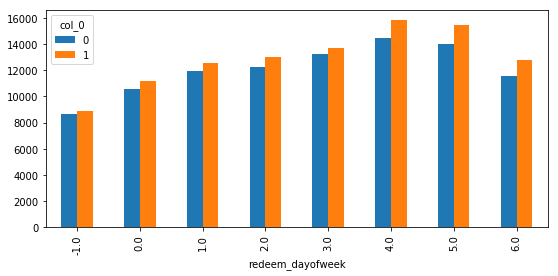

In [90]:
pd.crosstab(X_rand['redeem_dayofweek'], y_rand).plot(kind='bar')

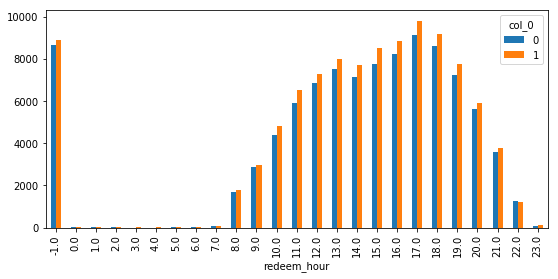

In [91]:
pd.crosstab(X_rand['redeem_hour'], y_rand).plot(kind='bar')

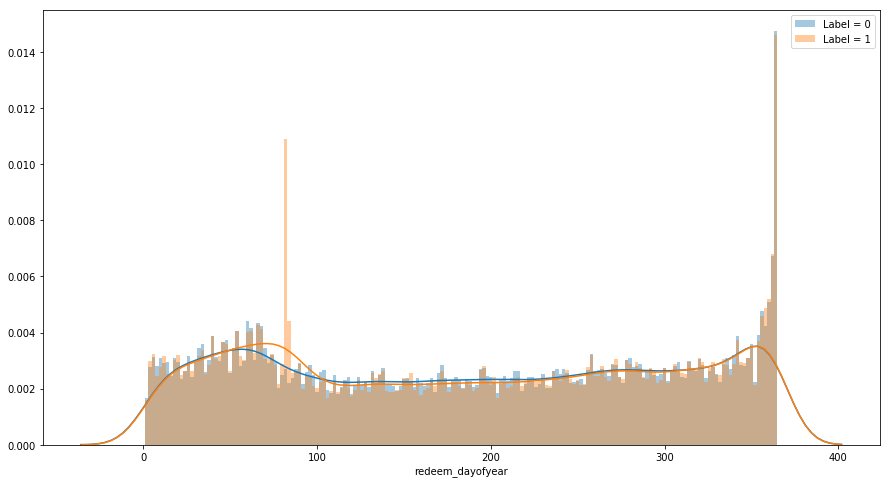

In [128]:

with change_figsize(15, 8):
    doy = X_rand['redeem_dayofyear']
    x_ = doy[doy != -1]
    y_ = y_rand[doy != -1]
    label_distplots(x_ , y_, bins=182)

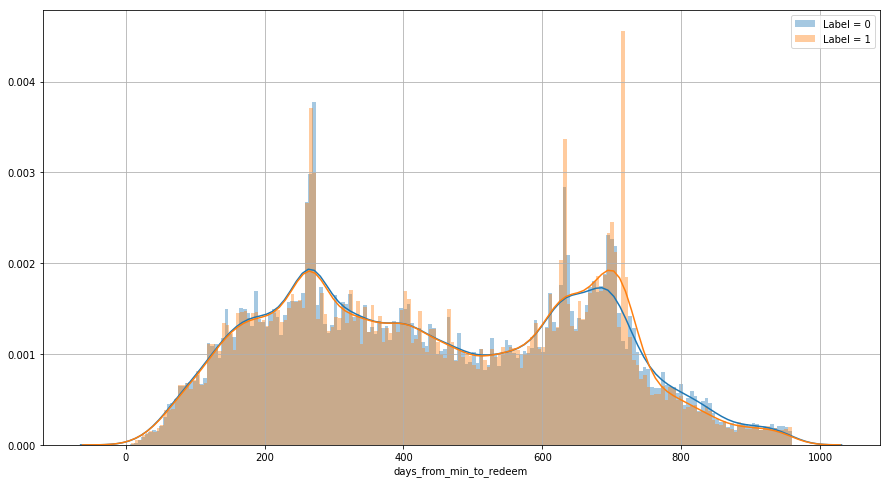

In [144]:
with change_figsize(15, 8):
    dfmtr = X_rand['days_from_min_to_redeem']
    mask = dfmtr != -1
    x_ = dfmtr[mask]
    y_ = y_rand[mask]
    label_distplots(x_ , y_, bins=182)
    plt.grid()

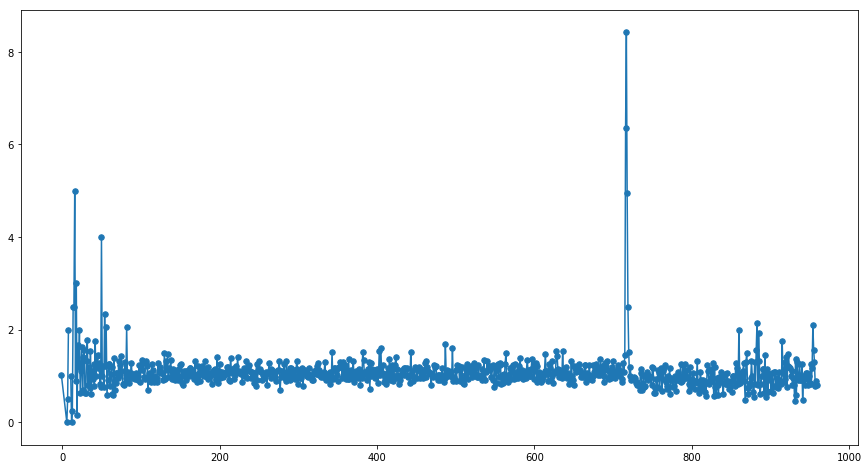

In [164]:
with change_figsize(15, 8):
    dfmtr = X_rand['days_from_min_to_redeem'].astype(int)
    dfmtr_ct = pd.crosstab(dfmtr, y_rand)
    dfmtr_ct['rate'] = dfmtr_ct.iloc[:, 1] / dfmtr_ct.iloc[:, 0]
    plt.plot(dfmtr_ct.index.values, dfmtr_ct['rate']);
    plt.scatter(dfmtr_ct.index.values, dfmtr_ct['rate'], s=30);

In [167]:
dfmtr_ct.iloc[705:720]

col_0,0,1,rate
days_from_min_to_redeem,,,
710,141,155,1.099291
711,115,107,0.930435
712,109,96,0.880734
713,82,105,1.280488
714,89,96,1.078652
715,108,157,1.453704
716,138,878,6.362319
717,100,842,8.420000
718,94,466,4.957447


In [136]:
clients = load_and_prepare.prepare_clients()[0]

[2020-01-24 23:20:01,860] load_and_prepare          INFO     Preparing clients...
[2020-01-24 23:20:04,094] load_and_prepare          INFO     Clients are ready


In [148]:
clients['first_issue_date'].min(), clients['first_issue_date'].max()

(Timestamp('2017-04-04 18:24:18'), Timestamp('2019-03-15 21:50:56'))

In [149]:
clients['first_redeem_date'].min(), clients['first_redeem_date'].max()

(Timestamp('2017-04-11 09:42:20'), Timestamp('2019-11-20 01:14:10'))

In [ ]:
clients['first_issue_date'].min()

In [143]:
min_datetime = datetime(2017, 4, 4)
min_datetime

datetime.datetime(2017, 4, 4, 0, 0)

In [169]:
min_datetime + timedelta(days=714), min_datetime + timedelta(days=720)

(datetime.datetime(2019, 3, 19, 0, 0), datetime.datetime(2019, 3, 25, 0, 0))

In [ ]:
min_datetime + timedelta(days=714)

In [172]:
%%time
clients, client_encoder = load_and_prepare.prepare_clients()
products, product_encoder = load_and_prepare.prepare_products()
purchases = load_and_prepare.prepare_purchases(client_encoder, product_encoder)

[2020-01-25 00:00:12,878] load_and_prepare          INFO     Preparing clients...
[2020-01-25 00:00:15,015] load_and_prepare          INFO     Clients are ready
[2020-01-25 00:00:15,016] load_and_prepare          INFO     Preparing products
[2020-01-25 00:00:15,277] load_and_prepare          INFO     Products are ready
[2020-01-25 00:00:15,279] load_and_prepare          INFO     Preparing purchases...
[2020-01-25 00:00:15,280] load_and_prepare          INFO     Loading purchases...
[2020-01-25 00:04:27,385] load_and_prepare          INFO     Purchases are loaded
[2020-01-25 00:04:27,496] load_and_prepare          INFO     Handling n/a values...
[2020-01-25 00:08:49,769] load_and_prepare          INFO     Label encoding...
[2020-01-25 00:10:34,661] load_and_prepare          INFO     Date and time conversion...
[2020-01-25 00:11:40,043] load_and_prepare          INFO     Purchases are ready


Wall time: 11min 27s


In [173]:
purchases['datetime'].min(), purchases['datetime'].max()

(Timestamp('2018-11-21 21:02:33'), Timestamp('2019-03-18 23:40:03'))